In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/FirstCompetition/FirstSubmission/

/content/drive/MyDrive/FirstCompetition/FirstSubmission


In [ ]:
!pip install visualkeras

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import visualkeras
from PIL import Image

tfk = tf.keras
tfkl = tfk.layers

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
dataset_base = '../dataset'
train_data_dir = dataset_base + '/training'
test_data_dir = dataset_base + '/test'

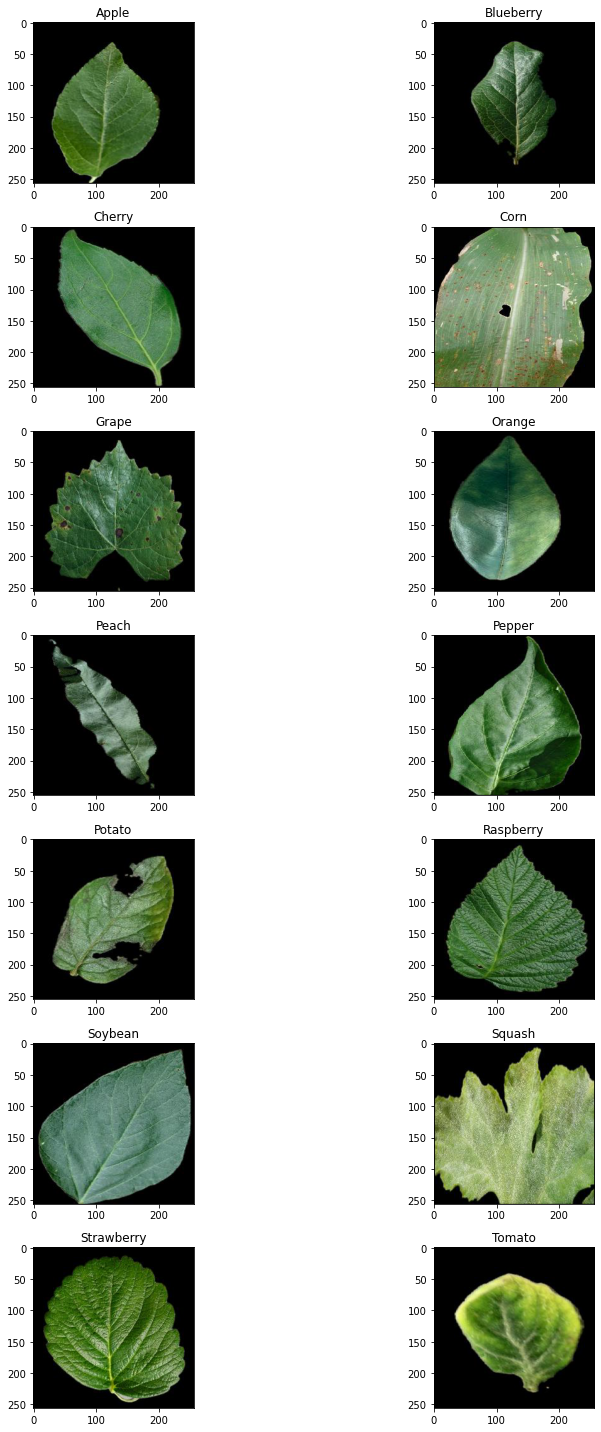

In [ ]:
labels = ['Apple',        # 0
          'Blueberry',    # 1
          'Cherry',       # 2
          'Corn',         # 3
          'Grape',        # 4
          'Orange',       # 5
          'Peach',        # 6
          'Pepper',       # 7
          'Potato',       # 8
          'Raspberry',    # 9
          'Soybean',      # 10
          'Squash',       # 11
          'Strawberry',   # 12
          'Tomato'        # 13
          ]

num_row = 7
num_col = 2
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,10*num_col))
for i in range(num_row*num_col):
  class_imgs = next(os.walk(train_data_dir + ('/{}/'.format( labels[i]))))[2]
  class_img = class_imgs[0]
  img = Image.open(train_data_dir + ('/{}/{}'.format( labels[i], class_img)))
  ax = axes[i//num_col, i%num_col]
  ax.imshow(np.array(img))
  ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

In [ ]:
img_height = 256
img_width = 256

batch_size = 32
epochs = 500

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1/255.,
    width_shift_range=0.3, height_shift_range=0.3,
    zoom_range=0.2, channel_shift_range=0.2,
    horizontal_flip=True, vertical_flip=True,
    rotation_range=30,
    brightness_range=(0.8,1.2),
    validation_split=0.1) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    color_mode = 'rgb',
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',  # set as validation data
    seed = seed)

validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(img_height, img_width),
    color_mode = 'rgb',
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',  # set as validation data
    seed = seed)

Found 15171 images belonging to 14 classes.
Found 1678 images belonging to 14 classes.


# Model

In [ ]:
def build_model(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    conv1 = tfkl.Conv2D(
        filters=8,
        kernel_size=(7, 7),
        strides = (2, 2),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(input_layer)
    conv2 = tfkl.Conv2D(
        filters=16,
        kernel_size=(7, 7),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(conv1)
    pool1 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv2)

    conv3 = tfkl.Conv2D(
        filters=32,
        kernel_size=(5, 5),
        strides = (2, 2),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool1)
    conv4 = tfkl.Conv2D(
        filters=32,
        kernel_size=(5, 5),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(conv3)
    pool2 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv4)

    conv5 = tfkl.Conv2D(
        filters=64,
        kernel_size=(5, 5),
        strides = (2, 2),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool2)
    conv6 = tfkl.Conv2D(
        filters=64,
        kernel_size=(5, 5),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(conv5)
    pool3 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv6)

    flattening_layer = tfkl.Flatten(name='Flatten')(pool3)
    flattening_layer = tfkl.Dropout(0.3, seed=seed)(flattening_layer)
    classifier_layer = tfkl.Dense(units=512, name='Classifier', kernel_initializer=tfk.initializers.GlorotUniform(seed), activation='relu')(flattening_layer)
    classifier_layer = tfkl.Dropout(0.3, seed=seed)(classifier_layer)
    output_layer = tfkl.Dense(units=14, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(classifier_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 8)       1184      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      6288      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        12832     
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        25632     
                                                             

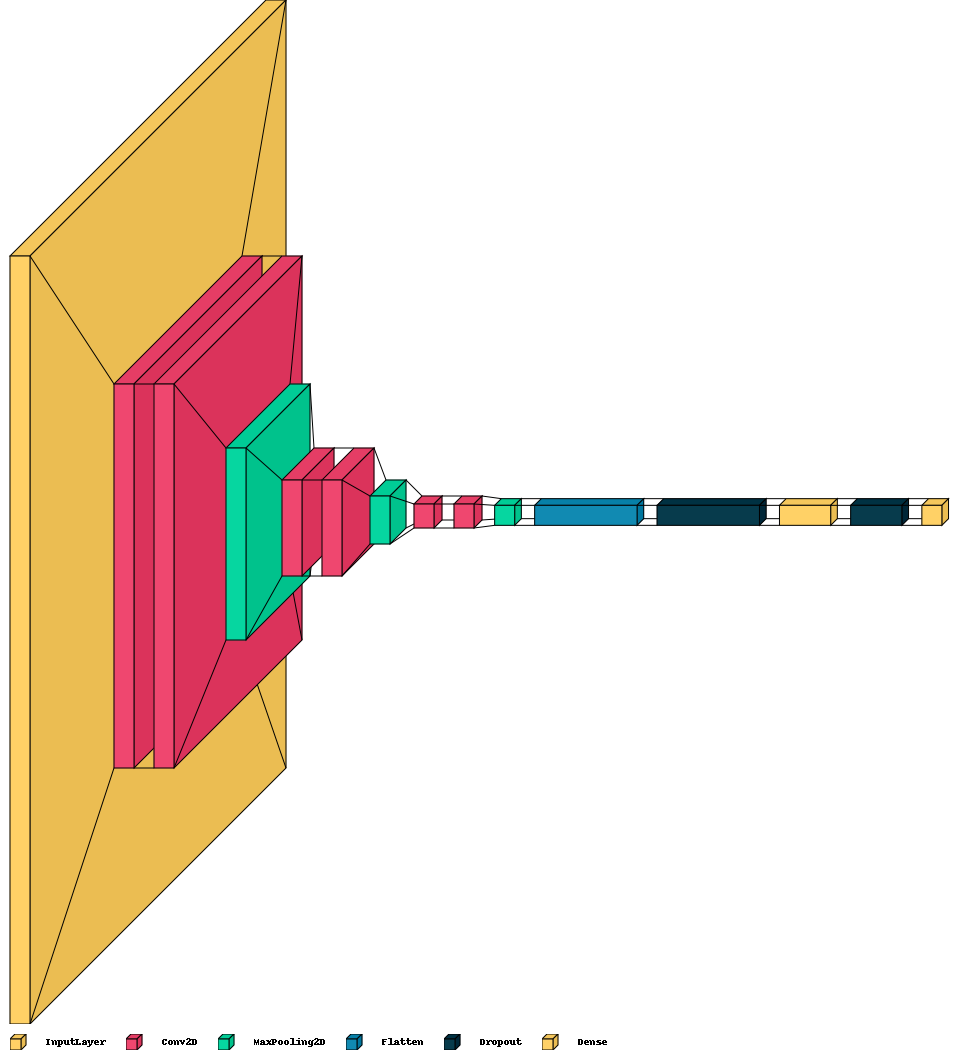

In [ ]:
input_shape = (256, 256, 3)

model = build_model(input_shape)
model.summary()
visualkeras.layered_view(model, legend=True, spacing=20, scale_xy=3)

In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('FirstSubmission')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

In [ ]:
callbacks = create_folders_and_callbacks(model_name='Model')

# Train the model
history = model.fit(
          x = train_generator,
          batch_size=batch_size,
          epochs = epochs,
          validation_data = validation_generator,
          callbacks = callbacks).history

In [ ]:
# Save best epoch model
#model.save("Model")

In [ ]:
model = tfk.models.load_model('Model')

In [ ]:
# test with no augmentations

test_datagen = ImageDataGenerator(
    rescale=1/255.)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    color_mode = 'rgb',
    batch_size=1,
    shuffle=False,
    class_mode='categorical',
    seed = seed)

prediction_prob = model.predict(test_generator)

# get actual predictions (higher predicted probability)
predictions = []
for el in prediction_prob:
  predictions.append(np.argmax(el,axis = 0))

# create confusion matrix
conf_mat = np.zeros((14,14))
for (pr,label) in zip(predictions,test_generator.labels):
  conf_mat[label][pr] += 1

# accuracy
true_positives = np.trace(conf_mat)
accuracy = float(true_positives) / conf_mat.sum()

# normalize confusion matrix
for row in conf_mat:
  row /= np.sum(row)

Found 879 images belonging to 14 classes.


accuracy:  0.8953356086461889


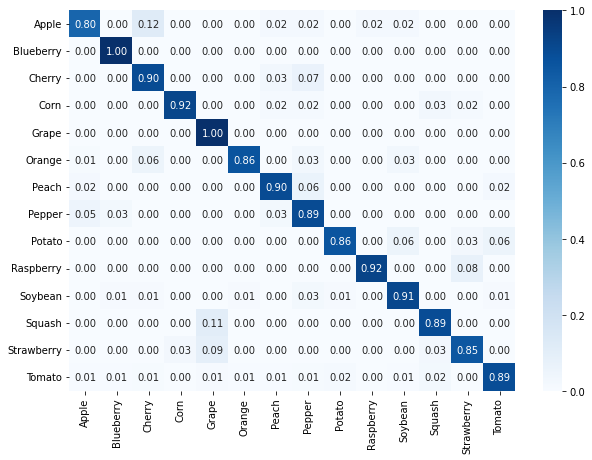

In [ ]:
df_cm = pd.DataFrame(conf_mat, index = labels, columns = labels)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='.2f')

print('accuracy: ',accuracy)

In [ ]:
# test on aug

test_datagen = ImageDataGenerator(
    rescale=1/255.,
    width_shift_range=0.5, height_shift_range=0.5,
    zoom_range=0.5, channel_shift_range=0.5,
    horizontal_flip=True, vertical_flip=True,
    rotation_range=90,
    brightness_range=(0.5,1.5)
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    color_mode = 'rgb',
    batch_size=1,
    shuffle=False,
    class_mode='categorical',
    seed = seed)

prediction_prob = model.predict(test_generator)

#get actual predictions (higher predicted probability)
predictions = []
for el in prediction_prob:
  predictions.append(np.argmax(el,axis = 0))

#create confusion matrix
conf_mat = np.zeros((14,14))
for (pr,label) in zip(predictions,test_generator.labels):
  conf_mat[label][pr] += 1

# accuracy
true_positives = np.trace(conf_mat)
accuracy = float(true_positives) / conf_mat.sum()

#normalize confusion matrix
for row in conf_mat:
  row /= np.sum(row)

Found 879 images belonging to 14 classes.


accuracy:  0.5767918088737202


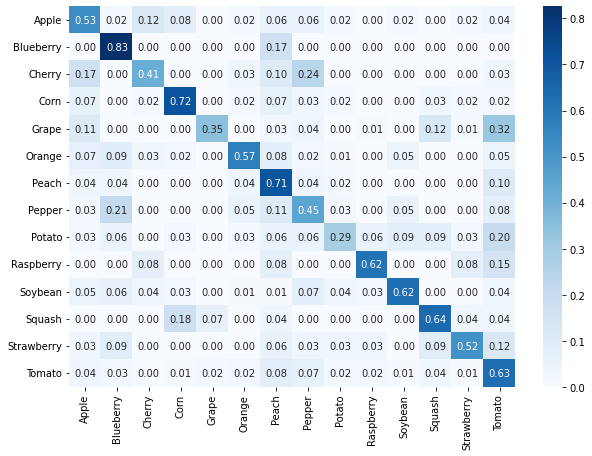

In [ ]:
df_cm = pd.DataFrame(conf_mat, index = labels, columns = labels)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='.2f')

print('accuracy: ', accuracy)